# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
X_train

,date,station,job,ferie,vacances
index,,,,,
2015-01-01_1J7,2015-01-01,1J7,1,1,1
2015-01-01_O2O,2015-01-01,O2O,1,1,1
2015-01-01_8QR,2015-01-01,8QR,1,1,1
2015-01-01_UMC,2015-01-01,UMC,1,1,1
2015-01-01_FK3,2015-01-01,FK3,1,1,1
...,...,...,...,...,...
2022-12-31_V2P,2022-12-31,V2P,0,0,1
2022-12-31_N9K,2022-12-31,N9K,0,0,1
2022-12-31_P6E,2022-12-31,P6E,0,0,1


In [ ]:
X_test

Text(0.5, 1.0, 'Evolution du nombre de validations par jour')

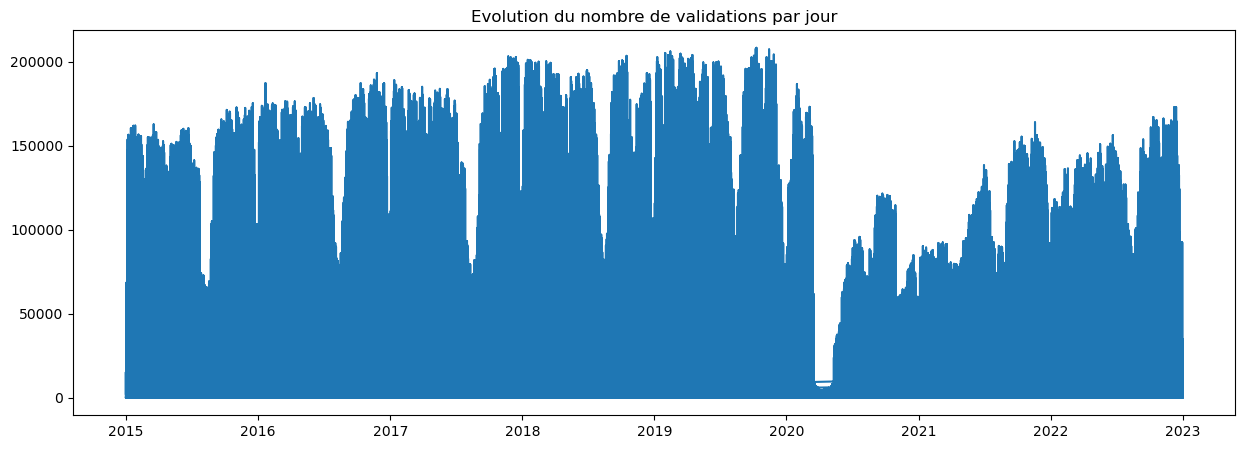

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(X_train['date'], y_train['y'])
plt.title('Evolution du nombre de validations par jour')


Text(0.5, 1.0, 'Station 1J7')

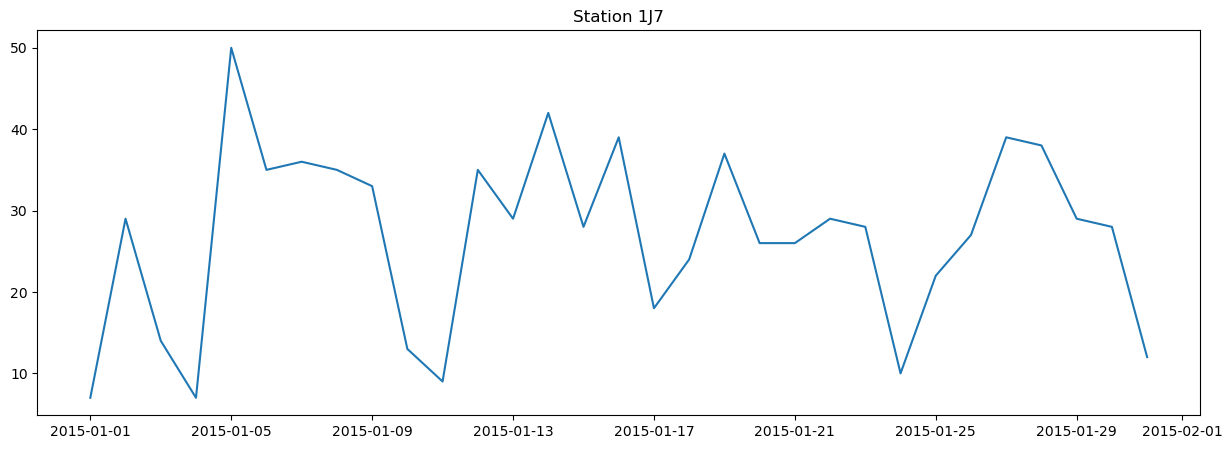

In [ ]:
X_plot = X_train.loc[(X_train['date'] > '2019-02-01')
                     & (X_train['date'] < '2019-03-01')
                     & (X_train['station'] == '1J7')]
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_train.loc[X_plot.index, 'y'])
plt.title('Station 1J7 pour un mois')


In [7]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [ ]:
def add_lags(df_x, df_y):
    ''' Add lags '''
    target_map = df_y['y'].to_dict()

    df_x['lagDay'] = (
        (df_x.date - pd.DateOffset(days=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)
    
    df_x['lagWeek'] = (
        (df_x.date - pd.DateOffset(days=7))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagMonth'] = (
        (df_x.date - pd.DateOffset(months=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagYear'] = (
        (df_x.date - pd.DateOffset(years=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    return df_x


In [9]:
X_train = create_features(X_train)
X_train = add_lags(X_train, y_train)
X_test = create_features(X_test)
X_test = add_lags(X_test, y_train)

In [ ]:
X_train.tail()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=X_train.dayofweek, y=y_train.y, ax=ax[0, 0])
sns.boxplot(x=X_train.month, y=y_train.y, ax=ax[0, 1])
sns.boxplot(x=X_train.day, y=y_train.y, ax=ax[1, 0])
sns.boxplot(x=X_train.year, y=y_train.y, ax=ax[1, 1])

In [11]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
X_test['station'] = X_test['station'].astype('category')

In [ ]:
estimator = xgb.XGBRegressor(enable_categorical=True, early_stopping_rounds=50)

param_grid = {
    'learning_rate': [0.1, 0.05],
    'n_estimators': [500, 700],
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv= KFold(n_splits=3, shuffle=True),  
    verbose=10,  
    n_jobs=-1
).fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=10)

print("Best params:", grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.1, n_estimators=500.........................
[CV 2/3; 1/4] START learning_rate=0.1, n_estimators=500.........................
[CV 3/3; 1/4] START learning_rate=0.1, n_estimators=500.........................
[CV 1/3; 2/4] START learning_rate=0.1, n_estimators=700.........................
[CV 2/3; 2/4] START learning_rate=0.1, n_estimators=700.........................
[0]	validation_0-rmse:8775.19138
[CV 3/3; 2/4] START learning_rate=0.1, n_estimators=700.........................
[1]	validation_0-rmse:7962.65987
[0]	validation_0-rmse:8780.10038
[2]	validation_0-rmse:7235.62877
[1]	validation_0-rmse:7971.58365
[3]	validation_0-rmse:6584.68218
[2]	validation_0-rmse:7249.06464
[CV 1/3; 3/4] START learning_rate=0.05, n_estimators=500........................
[4]	validation_0-rmse:6003.64977
[0]	validation_0-rmse:8767.51768
[3]	validation_0-rmse:6601.40979
[5]	validation_0-rmse:5487.20897
[1]	valida

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=10)

[0]	validation_0-rmse:9228.11643
[10]	validation_0-rmse:5807.44557
[20]	validation_0-rmse:3847.88563
[30]	validation_0-rmse:2751.61705
[40]	validation_0-rmse:2163.40294
[50]	validation_0-rmse:1856.16415
[60]	validation_0-rmse:1693.60417
[70]	validation_0-rmse:1609.47510
[80]	validation_0-rmse:1557.35389
[90]	validation_0-rmse:1511.57684
[100]	validation_0-rmse:1476.51734
[110]	validation_0-rmse:1447.86597
[120]	validation_0-rmse:1421.95437
[130]	validation_0-rmse:1407.32891
[140]	validation_0-rmse:1397.78432
[150]	validation_0-rmse:1388.15969
[160]	validation_0-rmse:1377.20279
[170]	validation_0-rmse:1361.21658
[180]	validation_0-rmse:1349.74751
[190]	validation_0-rmse:1336.17406
[200]	validation_0-rmse:1319.05372
[210]	validation_0-rmse:1308.60674
[220]	validation_0-rmse:1298.94628
[230]	validation_0-rmse:1288.52681
[240]	validation_0-rmse:1280.38144
[250]	validation_0-rmse:1271.15666
[260]	validation_0-rmse:1263.78027
[270]	validation_0-rmse:1256.54957
[280]	validation_0-rmse:1250.23

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

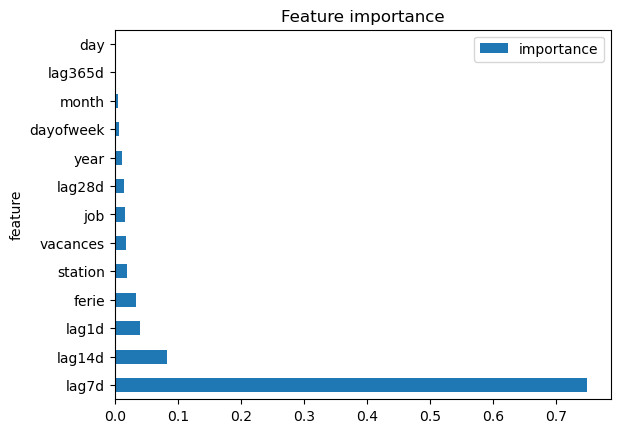

In [18]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [19]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred_vals = best_model.predict(X_test)
y_pred['y'] = np.clip(y_pred_vals, 0, None).astype(int) # Clip negative values to 0
y_pred.to_csv(file_path + 'y_pred.csv')

In [ ]:
X_test2 = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0)
X_test2['date'] = pd.to_datetime(X_test2['date'])
X_plot = X_test2.loc[(X_test2.date < '2023-02-01') & (X_test2.station == '1J7')] #FIXME
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_pred.loc[X_plot.index, 'y'])
plt.title('Station 1J7')

Best params: {'learning_rate': 0.05, 'n_estimators': 700} -> 106.59